The preprocessing of data focuses on extracting 15 key features that influence post engagement and virality. These features, such as title and content length, sentiment scores, upvotes, engagement velocity, and timing, provide insights into user behavior and post performance. By including metrics like popularity index, media presence, and upvote-to-downvote ratio, the dataset captures both quantitative and qualitative aspects of engagement. This structured preprocessing ensures that the data is comprehensive, enabling models to effectively analyze patterns and predict virality with greater accuracy.


In [1]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import nltk
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')  # Download VADER lexicon
nltk.download('movie_reviews')  # Download TextBlob corpora
nltk.download('punkt')  # Tokenizer data for TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = r'C:\Users\sharv\SMDM\SMDM Project\SMDM_Project_DataSet_V1.csv'
df = pd.read_csv(file_path)

# Convert 'updated_at' to datetime format for easier extraction of time-based features
df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce')

# 1. Post Title Length (Number of characters in the title)
df['title_length'] = df['title'].apply(lambda x: len(str(x)) if x is not None else 0)

# 2. Post Content Length (selftext) - Length of the post content (selftext)
df['selftext_length'] = df['selftext'].apply(lambda x: len(str(x)) if x is not None else 0)

# 3. Sentiment Score (Title + Selftext)
# Using TextBlob for simple sentiment score or VADER for more nuanced sentiment
analyzer = SentimentIntensityAnalyzer()

# Sentiment for title
df['title_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Sentiment for selftext (if available)
df['selftext_sentiment'] = df['selftext'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'] if pd.notna(x) else 0)

# 4. Upvotes
df['upvotes'] = df['updated_ups']

# 5. Downvotes / Gilded 
df['gilded'] = df['gilded']

# 6. Engagement Velocity (Rate of Change in Upvotes)
# For this calculation, we need to sort by 'updated_at' and calculate the difference in upvotes over time
df = df.sort_values(by='updated_at')
df['upvote_diff'] = df['updated_ups'].diff()  # Difference in upvotes
df['time_diff'] = df['updated_at'].diff().dt.total_seconds() / 3600  # Time difference in hours
df['engagement_velocity'] = df['upvote_diff'] / df['time_diff']  # Rate of upvotes per hour

# Handle NaN and infinite values in engagement_velocity
df['engagement_velocity'] = df['engagement_velocity'].replace([float('inf'), -float('inf')], 0)  # Replace inf with 0
df['engagement_velocity'] = df['engagement_velocity'].fillna(0)  # Replace NaN with 0

# 7 post Popularity Index (Upvotes + Gilded / Time Since Posting)
df['time_since_posting'] = (df['updated_at'] - df['updated_at'].min()).dt.total_seconds() / 3600  # Time since first post
df['popularity_index'] = (df['updated_ups'] + df['gilded']) / df['time_since_posting']

# Handle infinite values in popularity_index (caused by zero time_since_posting)
df['popularity_index'] = df['popularity_index'].replace([float('inf'), -float('inf')], 0)  # Replace inf with 0
df['popularity_index'] = df['popularity_index'].fillna(0)  # Replace NaN with 0

# 8 Time of Post (Hour, Day of Week, Month)
df['hour_of_post'] = df['updated_at'].dt.hour
df['day_of_week'] = df['updated_at'].dt.dayofweek  # Monday = 0, Sunday = 6
df['month_of_post'] = df['updated_at'].dt.month


# 9. Link Flair Type (e.g., "Discussion", "Question", "News")
df['link_flair_type'] = df['link_flair_richtext'].apply(lambda x: len(str(x)))

# 10. Is Gallery (Media)
df['is_gallery'] = df['is_gallery'].apply(lambda x: 1 if pd.notna(x) else 0)

# 11. Post Visibility (Crosspost Parent)
df['is_crosspost'] = df['crosspost_parent'].apply(lambda x: 1 if pd.notna(x) else 0)

# 12. Upvote to Downvote Ratio (if available) or upvotes / gilded
df['upvote_to_gilded_ratio'] = df['updated_ups'] / (df['gilded'] + 1)  # Added 1 to avoid division by zero

# Fill NaN or infinite values for the ratio
df['upvote_to_gilded_ratio'] = df['upvote_to_gilded_ratio'].replace([float('inf'), -float('inf')], 0)  # Replace inf with 0
df['upvote_to_gilded_ratio'] = df['upvote_to_gilded_ratio'].fillna(0)  # Replace NaN with 0

# Display the first few rows to check the features
df[['title_length', 'selftext_length', 'title_sentiment', 'selftext_sentiment', 'upvotes', 'gilded', 
    'engagement_velocity', 'popularity_index', 'hour_of_post', 'day_of_week', 'month_of_post', 
    'link_flair_type', 'is_gallery', 'is_crosspost', 'upvote_to_gilded_ratio']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sharv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sharv\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sharv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\sharv\AppData\Local\Temp\ipykernel_12472\3377668824.py:19: DtypeWarning: Columns (41,82,97) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,title_length,selftext_length,title_sentiment,selftext_sentiment,upvotes,gilded,engagement_velocity,popularity_index,hour_of_post,day_of_week,month_of_post,link_flair_type,is_gallery,is_crosspost,upvote_to_gilded_ratio
0,2,3,0.0000,0.0,54.0,0,0.0,0.0,14,0,3,2,0,0,54.0
341,43,3,-0.6249,0.0,1.0,0,0.0,0.0,14,0,3,2,0,0,1.0
340,64,3,0.6908,0.0,1.0,0,0.0,0.0,14,0,3,2,0,0,1.0
339,49,3,0.0000,0.0,1.0,0,0.0,0.0,14,0,3,2,0,0,1.0
338,35,3,0.0000,0.0,3.0,0,0.0,0.0,14,0,3,2,0,0,3.0


Defining Virality factor to predetermine if post is viral or not

In [2]:

# Define a more reasonable threshold (e.g., 10 upvotes for viral posts)
VIRAL_UPVOTES_THRESHOLD = 3

# 1. Virality Factor: Mark posts with more than 5 upvotes as 'viral' (1) and others as 'non-viral' (0)
df['virality_factor'] = df['updated_ups'].apply(lambda x: 1 if x > VIRAL_UPVOTES_THRESHOLD else 0)

# 2. Print the threshold value being used
print(f"Using a virality threshold of {VIRAL_UPVOTES_THRESHOLD} upvotes.")

# 3. Print the distribution of the virality factor (how many are viral vs non-viral)
viral_posts = df['virality_factor'].sum()
non_viral_posts = len(df) - viral_posts
print(f"Number of viral posts (virality_factor = 1): {viral_posts}")
print(f"Number of non-viral posts (virality_factor = 0): {non_viral_posts}")

# 4. Print a sample of the virality factor to verify classification
print("\nSample of the updated virality_factor classification:")
print(df[['updated_ups', 'virality_factor']].head(10))  # Displaying the first 10 rows for clarity


Using a virality threshold of 3 upvotes.
Number of viral posts (virality_factor = 1): 3164
Number of non-viral posts (virality_factor = 0): 6036

Sample of the updated virality_factor classification:
     updated_ups  virality_factor
0           54.0                1
341          1.0                0
340          1.0                0
339          1.0                0
338          3.0                0
337         17.0                1
336          1.0                0
335         12.0                1
334         17.0                1
333          1.0                0


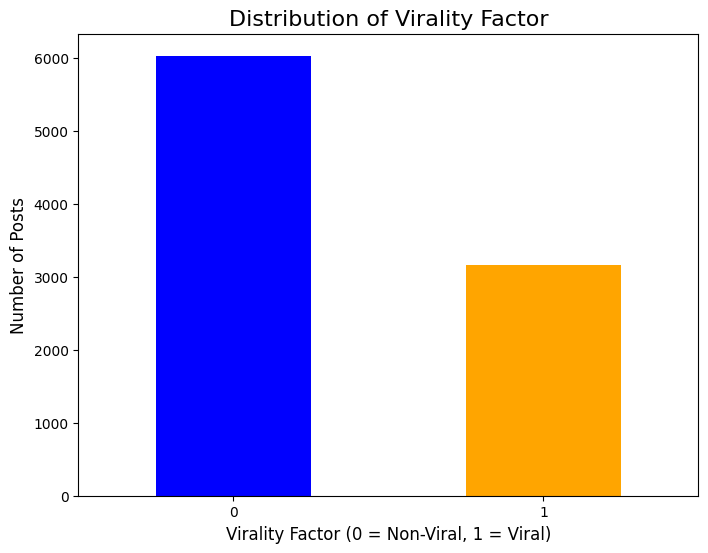

In [3]:
import matplotlib.pyplot as plt

# Plot the distribution of virality_factor
plt.figure(figsize=(8, 6))
df['virality_factor'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Virality Factor', fontsize=16)
plt.xlabel('Virality Factor (0 = Non-Viral, 1 = Viral)', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Spliting data into train and test sets and deciding the target variables

In [4]:

# Assuming df already contains the necessary features and virality_factor column
# Feature selection: Choose the features for model training
features = [
    'title_length', 
    'selftext_length', 
    'title_sentiment', 
    'selftext_sentiment', 
    'upvotes', 
    'gilded', 
    'engagement_velocity', 
    'popularity_index', 
    'hour_of_post', 
    'day_of_week', 
    'month_of_post',  
    'link_flair_type', 
    'is_gallery', 
    'is_crosspost', 
    'upvote_to_gilded_ratio'
]

# Target variable: 'virality_factor'
X = df[features]  # Features
y = df['virality_factor']  # Target variable

# 1. Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Impute missing values: Use SimpleImputer to fill in missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data, then transform the test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 3. Standardize the features for model training (important for models like LSTM)
scaler = StandardScaler()

# Fit and transform on the training data, and transform on the test data
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Print some statistics to ensure everything is split correctly and imputation is applied
print(f"Training set size after splitting: {X_train.shape[0]} samples")
print(f"Test set size after splitting: {X_test.shape[0]} samples")

# Checking for missing values after imputation
print("\nChecking for missing values after imputation (Training data):")
print(pd.isna(X_train_scaled).sum())  # Should show all zeros

print("Checking for missing values after imputation (Test data):")
print(pd.isna(X_test_scaled).sum())  # Should show all zeros

# Checking the first few rows of the scaled data
print("\nSample of scaled features (Training data):")
print(X_train_scaled[:5])


Training set size after splitting: 7360 samples
Test set size after splitting: 1840 samples

Checking for missing values after imputation (Training data):
0
Checking for missing values after imputation (Test data):
0

Sample of scaled features (Training data):
[[-0.76892494 -0.12154446 -0.13242531 -0.10421211 -0.11976667  0.
   0.01398753 -0.10880647  0.56780588 -0.86218531  0.23654617 -0.33493616
  -0.16583861 -0.05087439 -0.11873427]
 [-0.51791929 -0.12154446 -0.13242531 -0.10421211 -0.11976667  0.
   0.01398753 -0.10880647 -1.39684185  1.83695713  0.23654617 -0.33493616
  -0.16583861 -0.05087439 -0.11873427]
 [-0.72328755 -0.12154446 -0.13242531 -0.10421211 -0.11751432  0.
   0.01398753 -0.10687493 -0.90567992  0.03752884  0.23654617  1.54977329
  -0.16583861 -0.05087439 -0.11648206]
 [-0.17563885 -0.12154446 -0.13242531 -0.10421211 -0.11554352  0.
   0.01398753 -0.10518484 -0.90567992  0.03752884  0.23654617 -0.33493616
  -0.16583861 -0.05087439 -0.11451137]
 [ 0.14382289 -0.121544

Training LSTM Model:

Data Preparation: Features were scaled and reshaped into a 3D format [samples, timesteps, features] to align with LSTM input requirements.
Model Architecture: The model includes two LSTM layers (100 units each), a SpatialDropout1D layer for regularization, and a Dense layer with a sigmoid activation function for binary classification.
Compilation: The model was compiled using the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.
Training: The model was trained for 5 epochs with a batch size of 64, using the training data and validating on the test set.
Evaluation: Performance was assessed by evaluating accuracy and loss on the test set. Training and validation metrics were visualized through plots

C:\Users\sharv\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6866 - loss: 0.6455 - val_accuracy: 0.7239 - val_loss: 0.5519
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7270 - loss: 0.5462 - val_accuracy: 0.7543 - val_loss: 0.5076
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7581 - loss: 0.5120 - val_accuracy: 0.7772 - val_loss: 0.4812
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7807 - loss: 0.4900 - val_accuracy: 0.7946 - val_loss: 0.4602
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 0.4562 - val_accuracy: 0.8033 - val_loss: 0.4529


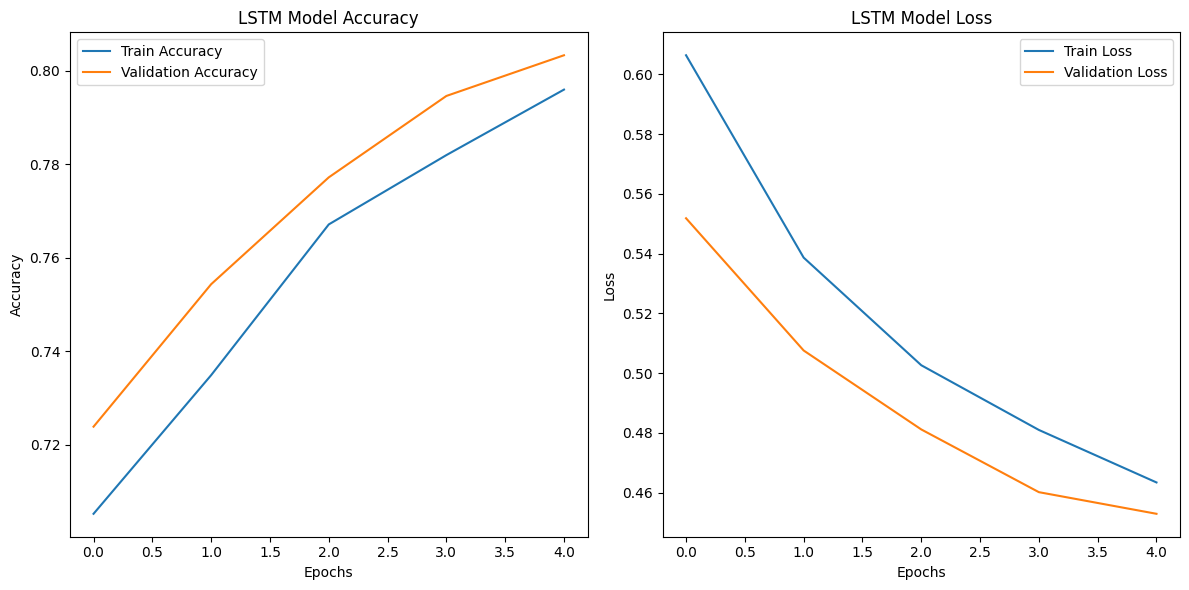

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8028 - loss: 0.4529
LSTM Test Accuracy: 0.803260862827301
LSTM Test Loss: 0.4529477059841156


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Convert X_train_scaled and X_test_scaled to tensors
X_train_lstm = X_train_scaled  # For simplicity, we're using the same scaled features
X_test_lstm = X_test_scaled

# Reshape data for LSTM (LSTM expects 3D input [samples, timesteps, features])
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))  # 1 timestep
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))  # 1 timestep

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, return_sequences=False))
lstm_model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test))

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the LSTM model
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Test Accuracy: {lstm_test_accuracy}")
print(f"LSTM Test Loss: {lstm_test_loss}")


Training CNN Model:

Epoch 1/5


C:\Users\sharv\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6758 - loss: 0.6235 - val_accuracy: 0.7326 - val_loss: 0.5567
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7260 - loss: 0.5525 - val_accuracy: 0.7647 - val_loss: 0.5223
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7485 - loss: 0.5414 - val_accuracy: 0.7679 - val_loss: 0.5090
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7661 - loss: 0.5181 - val_accuracy: 0.7647 - val_loss: 0.5074
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7737 - loss: 0.5015 - val_accuracy: 0.7842 - val_loss: 0.4771


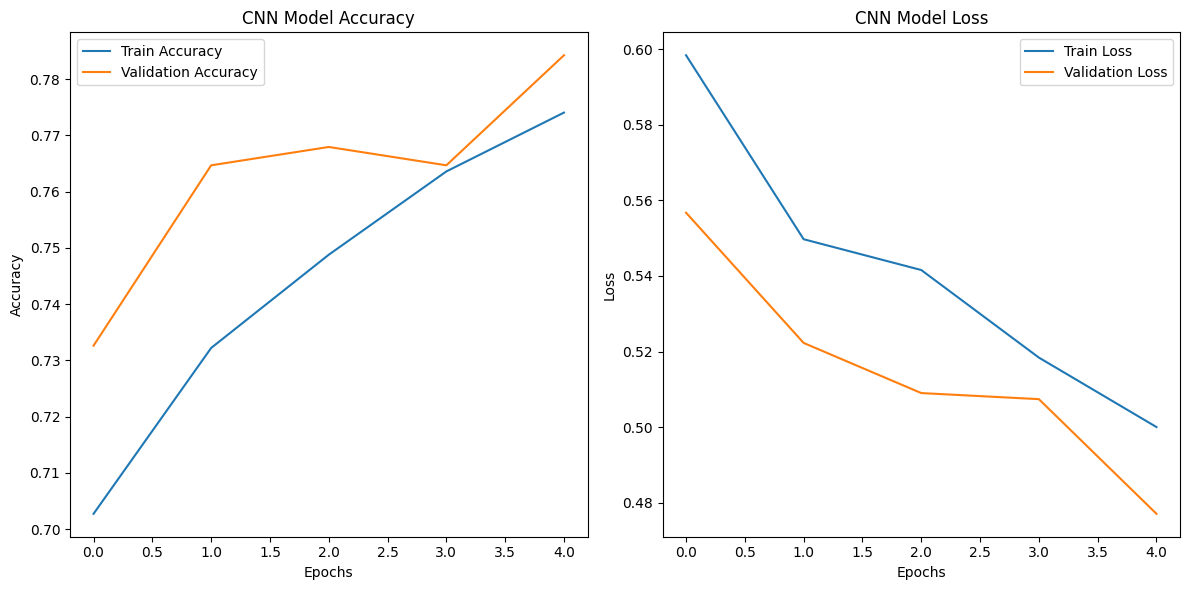

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7866 - loss: 0.4824
CNN Test Accuracy: 0.7842391133308411
CNN Test Loss: 0.4771079123020172


In [6]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

# Reshape data for CNN (CNN expects 3D input [samples, timesteps, features])
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))  # 1 feature per timestep
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))  # 1 feature per timestep

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=64, validation_data=(X_test_cnn, y_test))

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Test Accuracy: {cnn_test_accuracy}")
print(f"CNN Test Loss: {cnn_test_loss}")

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Train the model on the training data
linear_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# Display the first 10 predictions and actual values
print("\nFirst 10 Predictions vs Actual Values:")
for pred, actual in zip(y_pred_linear[:10], y_test[:10]):
    print(f"Predicted: {pred:.4f}, Actual: {actual}")

Mean Squared Error (MSE): 0.2137
R-squared (R2 Score): 0.0421

First 10 Predictions vs Actual Values:
Predicted: 0.5295, Actual: 1
Predicted: 0.3190, Actual: 0
Predicted: 0.3867, Actual: 1
Predicted: 0.2955, Actual: 1
Predicted: 0.3053, Actual: 1
Predicted: 0.3879, Actual: 1
Predicted: 0.3301, Actual: 1
Predicted: 0.2991, Actual: 0
Predicted: 0.3513, Actual: 0
Predicted: 0.3167, Actual: 0


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


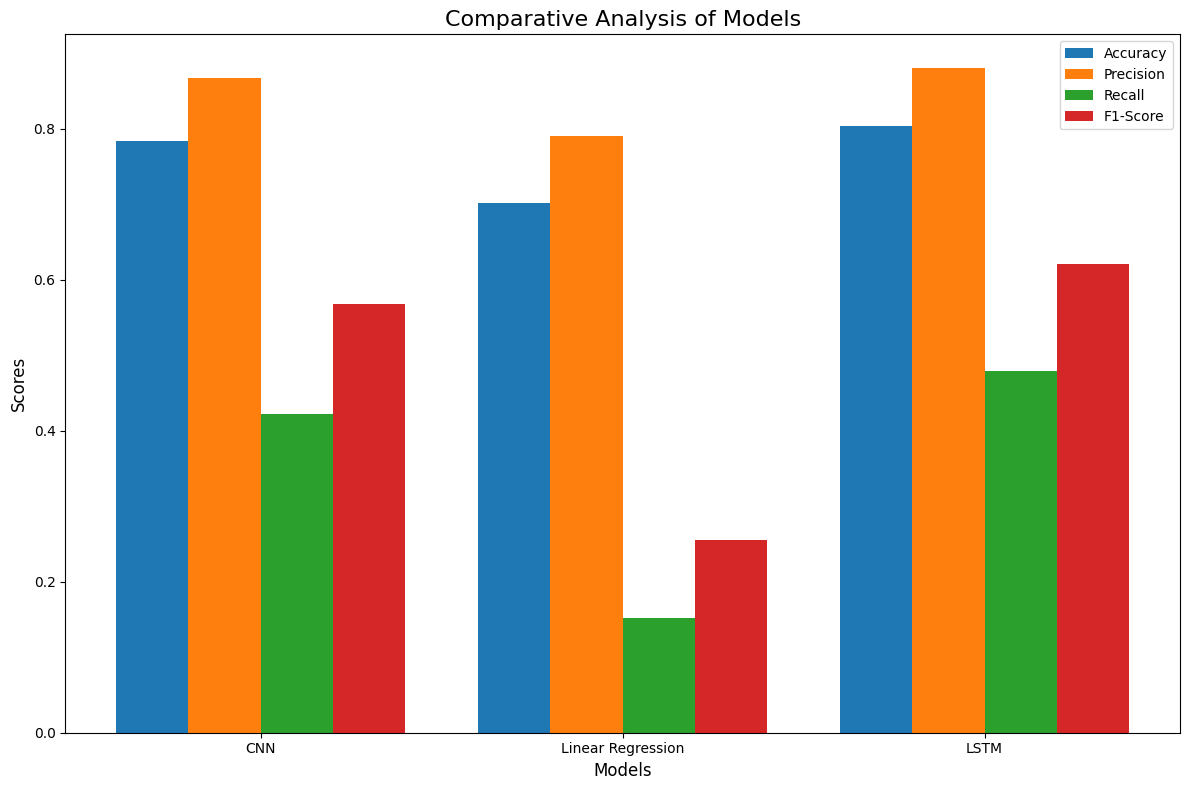

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

import matplotlib.pyplot as plt

# Calculate metrics for CNN
cnn_precision = precision_score(y_test, cnn_model.predict(X_test_cnn).round())
cnn_recall = recall_score(y_test, cnn_model.predict(X_test_cnn).round())
cnn_f1 = f1_score(y_test, cnn_model.predict(X_test_cnn).round())
cnn_accuracy = cnn_test_accuracy

# Calculate metrics for Linear Regression (threshold = 0.5 for binary classification)
y_pred_linear_binary = (y_pred_linear >= 0.5).astype(int)
linear_precision = precision_score(y_test, y_pred_linear_binary)
linear_recall = recall_score(y_test, y_pred_linear_binary)
linear_f1 = f1_score(y_test, y_pred_linear_binary)
linear_accuracy = accuracy_score(y_test, y_pred_linear_binary)

# Calculate metrics for LSTM
lstm_precision = precision_score(y_test, lstm_model.predict(X_test_lstm).round())
lstm_recall = recall_score(y_test, lstm_model.predict(X_test_lstm).round())
lstm_f1 = f1_score(y_test, lstm_model.predict(X_test_lstm).round())
lstm_accuracy = lstm_test_accuracy

# Combine metrics into a dictionary for visualization
metrics = {
    "Model": ["CNN", "Linear Regression", "LSTM"],
    "Accuracy": [cnn_accuracy, linear_accuracy, lstm_accuracy],
    "Precision": [cnn_precision, linear_precision, lstm_precision],
    "Recall": [cnn_recall, linear_recall, lstm_recall],
    "F1-Score": [cnn_f1, linear_f1, lstm_f1]
}

# Convert metrics to a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Plot the metrics
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics["Model"]))  # the label locations
width = 0.2  # the width of the bars

# Plot each metric
plt.bar(x - 1.5 * width, metrics["Accuracy"], width, label="Accuracy")
plt.bar(x - 0.5 * width, metrics["Precision"], width, label="Precision")
plt.bar(x + 0.5 * width, metrics["Recall"], width, label="Recall")
plt.bar(x + 1.5 * width, metrics["F1-Score"], width, label="F1-Score")

# Add labels, title, and legend
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Comparative Analysis of Models", fontsize=16)
plt.xticks(x, metrics["Model"], fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
From the chart and the metrics provided, the following analysis can be made:

### Model Performance:
1. **LSTM**:
    - **Best Overall Performance**: LSTM has the highest **Accuracy (0.803)** and **F1-Score (0.621)**, making it the most balanced model.
    - **High Precision (0.881)**: Indicates that it avoids false positives effectively.
    - **Moderate Recall (0.479)**: Captures a good number of true positives but leaves room for improvement.

2. **CNN**:
    - **High Precision (0.867)**: Suggests it is good at avoiding false positives.
    - **Moderate Accuracy (0.784)** and **F1-Score (0.568)**: Performs well overall but not as balanced as LSTM.
    - **Low Recall (0.422)**: Indicates it misses many true positives.

3. **Linear Regression**:
    - **Lowest Performance**: Linear Regression has the lowest **Accuracy (0.702)**, **F1-Score (0.255)**, and **Recall (0.152)**.
    - **High Precision (0.790)**: Indicates it avoids false positives but struggles to identify true positives.

### Comparative Analysis:
- **LSTM vs CNN**:
  - LSTM outperforms CNN in **Accuracy**, **Recall**, and **F1-Score**, making it the better model overall.
  - CNN has slightly lower precision but struggles with recall, making it less balanced.

- **LSTM vs Linear Regression**:
  - LSTM significantly outperforms Linear Regression in all metrics, especially **Recall** and **F1-Score**, indicating its suitability for this classification task.

- **CNN vs Linear Regression**:
  - CNN performs better than Linear Regression in all metrics except **Precision**, where Linear Regression slightly edges out.

### Key Insights:
- **LSTM is the most balanced model**, excelling in both precision and recall, making it ideal for this task.
- **CNN is a close second**, with high precision but lower recall, indicating it is more conservative in predicting positives.
- **Linear Regression is the weakest model**, struggling with recall and overall performance, making it unsuitable for this task.

The **AUC-ROC Curve** (Area Under the Receiver Operating Characteristic Curve) is a performance measurement for classification problems at various threshold settings. It plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at different thresholds. The **AUC** (Area Under the Curve) represents the degree of separability; the higher the AUC, the better the model is at distinguishing between classes.

Here is the code to calculate and plot the AUC-ROC curve for all the models trained above

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


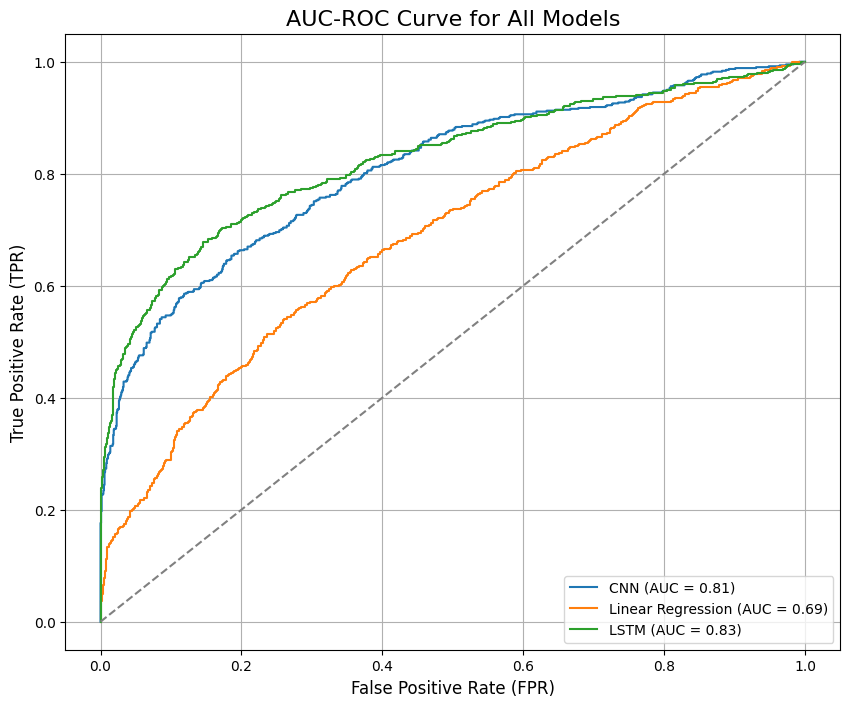

In [11]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for each model
models = {
    "CNN": (y_test, cnn_model.predict(X_test_cnn).ravel()),
    "Linear Regression": (y_test, y_pred_linear),
    "LSTM": (y_test, lstm_model.predict(X_test_lstm).ravel())
}

plt.figure(figsize=(10, 8))

for model_name, (y_true, y_scores) in models.items():
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.title("AUC-ROC Curve for All Models", fontsize=16)
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid()
plt.show()